# Machine Learning Lab 2025
Datenset available on: <a> https://www.kaggle.com/datasets/abhishekdave9/digital-habits-vs-mental-health-dataset</a> 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shap
import time

#sns.color_palette("husl")
#plt.style.use("seaborn-v0_8-whitegrid")
from matplotlib.colors import LinearSegmentedColormap

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import (
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    roc_curve, 
    auc,
    roc_auc_score, 
    precision_recall_curve, 
    average_precision_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier as xgb

from sklearn.tree import plot_tree
import xgboost as xgb_plot 


<hr>

## 1. Problemdefinition & Zielvariable

<b>Kurzbeschreibung:</b>
Ziel ist die Klassifikation des Stressniveaus. Der Fokus liegt auf den Zusammenhängen zwischen Social-Media-Nutzung, Schlafdauer und Screen Time im Kontext mentaler Gesundheit. Angesichts der dauerhaften Präsenz digitaler Medien soll geprüft werden, welche dieser Faktoren messbare Beiträge zu erhöhtem Stress liefern.

<b>Beschreibung der Zielvariable:</b>
Die Variable `stress_level` liegt auf eroer definiert durch eine ordinalskalierte Skala von 0 bis 10. Für das binäre Klassifikationsziel wird sie in eine neue Zielgröße überführt. Werte ab 8 werden als „sehr gestresst“ kodiert, Werte darunter als „nicht gestresst“. Die Transformation erzeugt eine klare, zweistufige Entscheidungsstruktur.

<b>Kurzinfo zu Quelle und Struktur:</b>
Das Dataset besteht aus 100.000 synthetisch generierten Beobachtungen mit je sechs Variablen. Die Generierung erfolgte mit Randomisierungsalgorithmen, wobei Abhängigkeiten zwischen den Variablen auf Basis publizierter wissenschaftlicher Erkenntnisse modelliert wurden. Die Daten sind demnach ausdrücklich nicht empirisch erhoben.

<hr>

### 2. Datenimport & Exploration 
- Daten laden, df.head(), df.info(), df.describe()
- Erste Visualisierungen (Klassenverteilung, Korrelationen, Missing Values).
- Kurze Reflexion: Was fällt auf, was könnte problematisch sein?


In [2]:
df = pd.read_csv('./digital_habits_vs_mental_health.csv')
df.head(10)

,screen_time_hours,social_media_platforms_used,hours_on_TikTok,sleep_hours,stress_level,mood_score
0,10.3,2,5.3,4.4,10,5
1,6.5,5,3.5,6.2,8,8
2,9.1,4,2.8,6.6,7,8
3,6.5,3,2.5,6.5,7,9
4,2.1,3,1.2,7.8,2,10
5,5.5,5,1.8,3.4,10,5
6,4.7,5,1.0,4.7,9,9
7,3.0,5,1.6,6.8,6,10
8,6.0,2,3.1,7.5,5,10
9,4.5,3,2.6,7.8,7,10


<b>Kurzinterpretation:</b> Es handelt sich um Datensätze die Daten zur täglicher Bildschirmnutzung, Schlafdauer und mentalen Gesundheit umfassen. <br>
Sie bestehen aus <b>6 Variablen</b>, davon:

<b>3x metrische Variablen, die eine zeitliche Dauer in Stunden erfassen:</b>
- Bildschirmzeit (`screen_time_hours`)
- Zeit auf TikTok (`hours_on_TikTok`)
- Schlafdauer (`sleep_hours`)
<br> <br>

<b>2x ordinale Variablen, die eine subjektive Einschätzung erfassen:</b>
- Stresslevel ( `stress_level` ), [0, 10], mit 10 = höchster Stress)
- Stimmung (`mood_score`), [0, 10], mit 10 = positivste Stimmung
<br> <br>

<b>1x diskret-metrische Variable zur Anzahl:</b>
- Anzahl benutzter Social Media Plattformen (`social_media_platforms_used`), später als `platforms_count` geführt um Platz zu sparen




***
### 2.1 Explorative Datenanalyse
Ziel: Gefühl für die Daten bekommen, erste Hypothesen entwickeln und ggf. Lücken identifizieren

In [3]:
# Ändere den Namen, da er sehr lang ist
df = df.rename(columns={
    'social_media_platforms_used': 'platforms_count'
})

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   screen_time_hours  100000 non-null  float64
 1   platforms_count    100000 non-null  int64  
 2   hours_on_TikTok    100000 non-null  float64
 3   sleep_hours        100000 non-null  float64
 4   stress_level       100000 non-null  int64  
 5   mood_score         100000 non-null  int64  
dtypes: float64(3), int64(3)
memory usage: 4.6 MB


In [5]:
df.describe()

,screen_time_hours,platforms_count,hours_on_TikTok,sleep_hours,stress_level,mood_score
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000
mean,6.003505,2.997820,2.401433,6.988489,6.179590,9.06076
std,1.987073,1.414452,1.079111,1.466330,2.045409,1.27847
min,1.000000,1.000000,0.200000,3.000000,1.000000,2.00000
25%,4.700000,2.000000,1.600000,6.000000,5.000000,8.00000
50%,6.000000,3.000000,2.300000,7.000000,6.000000,10.00000
75%,7.300000,4.000000,3.100000,8.000000,8.000000,10.00000
max,12.000000,5.000000,7.200000,10.000000,10.000000,10.00000


<b>Kurzinterpretation:</b> Auffällig scheint hier vorallem, dass die min-Werte für `stress_level`und `mood_score` nicht 0 sondern 2 bzw 1 sind. Außerdem liegt der Mittelwert des `mood_score` bei 9.06 was sehr ungewöhlich ist, zumal anzunehmen wäre, dass ein hohes mittleres `stress_level` von 6.18 eher negativ mit dem Stimmungslevel korreliert. Da die Daten künstlich generiert sind, ist das nicht weiter verwunderlich. Trotzdem möchte ich anmerken, dass besonders die Werte zum `mood_score` stark im Gegensatz zur häufig beschriebenen "Tendenz zur Mitte" der subjektiven Datenerhebung steht. 

In [6]:
# Gibt zusätzlich übersichtliche Auskunft zu Datentypen
df.dtypes

screen_time_hours    float64
platforms_count        int64
hours_on_TikTok      float64
sleep_hours          float64
stress_level           int64
mood_score             int64
dtype: object

<b>Interpretation:</b> Numerische Werte, entweder ganzzahlige oder in Fließkommadarstellung

In [7]:
# Überprüft ob Missing Values vorliegen.
print(df.isnull().any())

screen_time_hours    False
platforms_count      False
hours_on_TikTok      False
sleep_hours          False
stress_level         False
mood_score           False
dtype: bool


<b>Kurzinterpretation:</b> Es liegen keine Missing Values vor

***
### 2.2. Zielvariable & Features
Um eine binäre Klassifikation durchführen zu können, wird ein Schwellenwert für `stress_level` eingeführt. Werte >= 8 werden dazu als `high stress` klassifiziert. Der Wert ergibt sich aus dem 75% Quartil. 
Die Reduktion der 10-stufigen, ordinal skalierten Stressskala vereinfacht das Klassifikationsproblem durch eine binäre Zielvariable `high_stress`. Die Nutzung des Models Logistische Regression wird so ermöglicht. Ergebnisse sind leichter interpretierbar. 

In [8]:
# Alternativ: astype(int) liefert 0 oder 1

df['high_stress'] = (df['stress_level'] >= 8).astype(bool)

In [9]:
# Zielvariable (y)
y = df["high_stress"].astype(int)

In [10]:
# Feature-Spalten (ohne Target Variable)
num_features = ["sleep_hours", "hours_on_TikTok", "screen_time_hours", "mood_score"]

cat_features = []

In [11]:
# Feature-Matrix (X)
X = df[num_features + cat_features].copy()

In [12]:
X.describe()

,sleep_hours,hours_on_TikTok,screen_time_hours,mood_score
count,100000.000000,100000.000000,100000.000000,100000.00000
mean,6.988489,2.401433,6.003505,9.06076
std,1.466330,1.079111,1.987073,1.27847
min,3.000000,0.200000,1.000000,2.00000
25%,6.000000,1.600000,4.700000,8.00000
50%,7.000000,2.300000,6.000000,10.00000
75%,8.000000,3.100000,7.300000,10.00000
max,10.000000,7.200000,12.000000,10.00000


***
### 2.3. Visualisierungen mit matplotlib  
Outlier, Klassenverteilung, Missing Values können schnell identifiziert werden

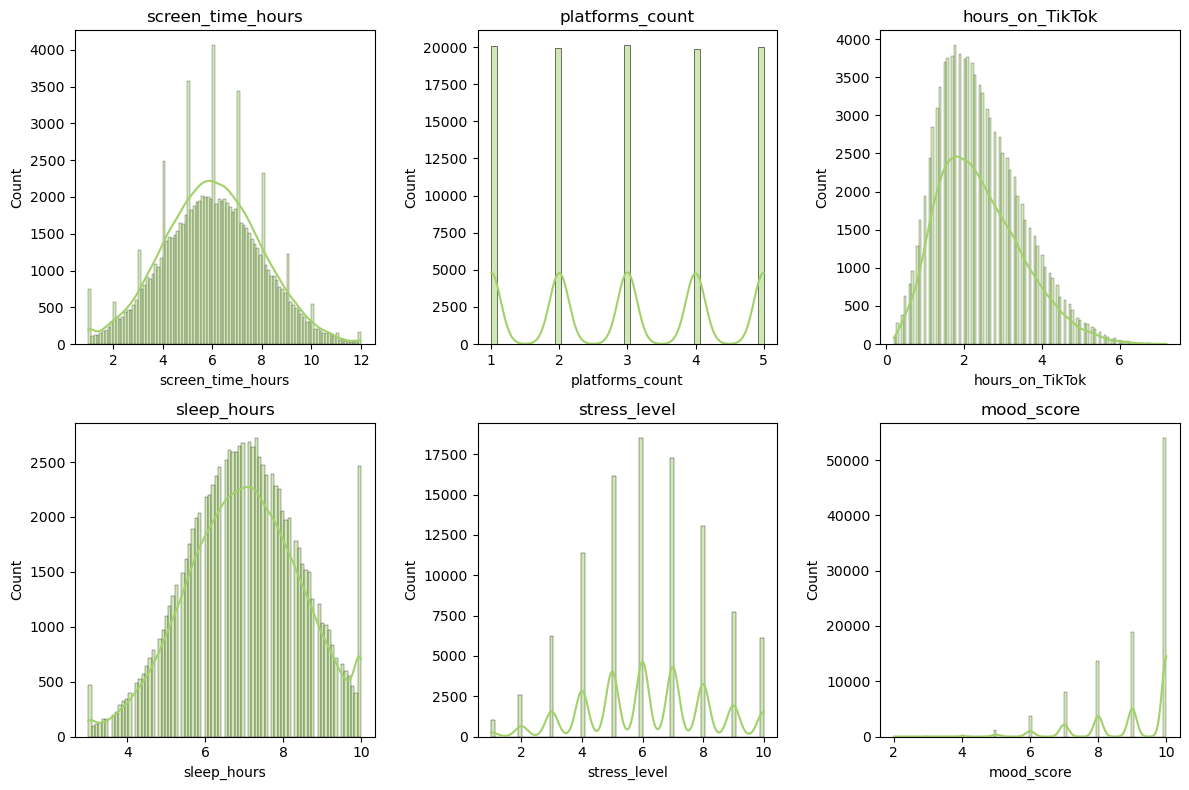

In [13]:
num_cols = ['screen_time_hours', 'platforms_count', 'hours_on_TikTok',
            'sleep_hours', 'stress_level', 'mood_score']

plt.figure(figsize=(12, 8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], kde=True, color="#a1d26a")
    plt.title(col)
plt.tight_layout()
plt.show()


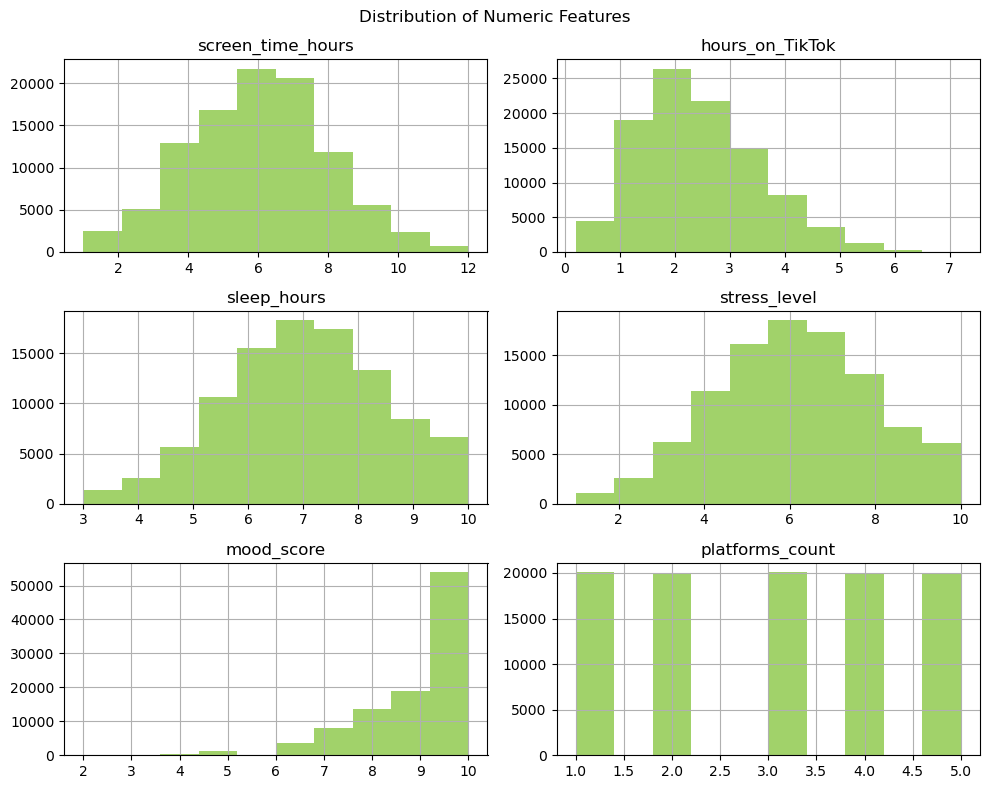

In [14]:
numeric_cols = ["screen_time_hours", "hours_on_TikTok", "sleep_hours", "stress_level", "mood_score", "platforms_count"]

df[numeric_cols].hist(bins=10, figsize=(10, 8), color='#a1d26a')
plt.suptitle("Distribution of Numeric Features")
plt.tight_layout()
#plt.savefig("platforms_distribiution.png", dpi=300, bbox_inches="tight")
plt.show()

<b>Kurzinterpretation:</b>
Die Anzahl der genutzten Social-Media-Plattformen (`platforms_count`) ist gleichmäßig verteilt. Diese Verteilung erscheint wenig plausibel für reale Beobachtungsdaten und spricht dafür, dass es sich um synthetisch generierte Daten handelt.

Das Stresslevel (`stress_level`) ist näherungsweise normalverteilt, mit einem Modalwert von 6.

Beim `mood_score` zeigt sich eine ausgeprägte Häufung am oberen Skalenende: Über die Hälfte der Befragten gibt den Maximalwert von 10 an. Die Verteilung ist stark rechtsschief, was ungewöhnlich ist und darauf hindeutet, dass die Werte entweder nicht realistisch verteilt sind oder im Rahmen der Datengenerierung vereinfacht wurden.

Die Schlafdauer (`sleep_hours`) weist ebenfalls eine annähernde Normalverteilung mit Mittelwert 6 Stunden auf, zeigt jedoch einen auffälligen Anstieg bei exakt 10 Stunden. Da dies zugleich den Maximalwert der Skala darstellt, liegt die Vermutung nahe, dass eine künstliche Begrenzung implementiert wurde oder höhere Werte zusammengefasst wurden (z. B. durch Binning). Dies kann die Aussagekraft der Variable einschränken, da Unterschiede im oberen Wertebereich nicht mehr differenziert abgebildet werden. Der Wertebereich 1-10 ist ungünstig wählt, womöglich um Skalierung zu vermeiden. Probleme für die Brauchbarkeit der Ergebnisse ergeben sich vorallem daher, dass die als gesund geltende Schlafdauer bei etwa 7–9 Stunden liegt. 

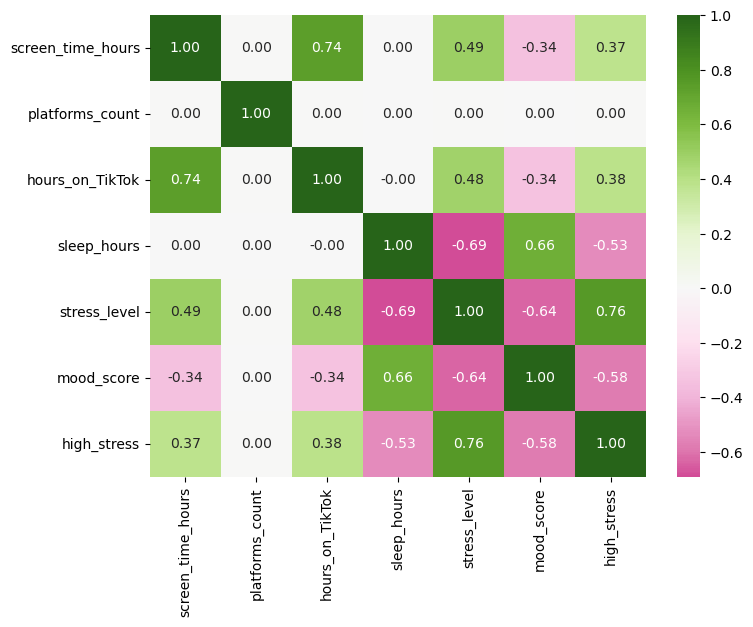

In [15]:
corr = df.corr(numeric_only=True)

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr,
    annot=True,         
    cmap='PiYG',    
    center=0,           
    fmt=".2f"           
)
#plt.title('Korrelationsmatrix')
plt.savefig("korrelationsmatrix.png", dpi=300, bbox_inches="tight")
plt.show()


In [16]:
# Auf Korrelationen mit "high_stress" prüfen
corr_target = df.corr(numeric_only=True)['high_stress'].sort_values(ascending=False)
print(corr_target)

high_stress          1.000000
stress_level         0.759690
hours_on_TikTok      0.380421
screen_time_hours    0.373359
platforms_count      0.003024
sleep_hours         -0.528651
mood_score          -0.581020
Name: high_stress, dtype: float64


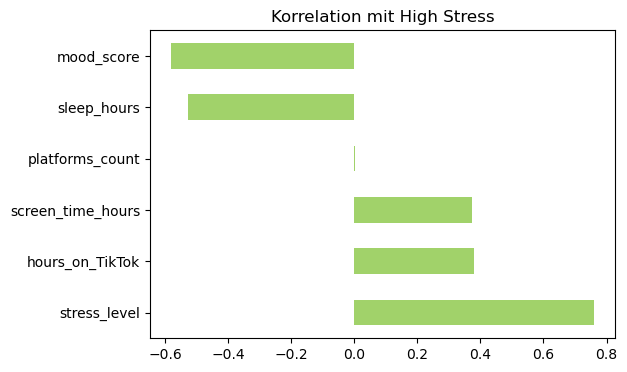

In [17]:
corr_target.drop('high_stress').plot(kind='barh', figsize=(6,4), color='#a1d26a')
plt.title('Korrelation mit High Stress')
plt.show()

<b>Kurzinterpretation:</b> Die Funktion .corr() berechnet die Pearson-Korrelation für numerische Variablen. 

- Eine <b>höhere Schlafdauer</b> und ein <b>höherer Stimmungswert</b> korrelieren negativ mit der Klassifikaton als `high_stress = True `
- Die <b>Anzahl der genutzten Social Media Plattformen</b> hat keinen Einfluss -> Erwartbar, da Werte gleichmäßig verteilt sind

Aus der Variable `stress_level` wurde `high_stress` abgeleitet, weshalb sie im weiteren Verlauf aus dem Datensatz entfernt werden muss um <b>Data-Leakage</b> zu vermeiden.

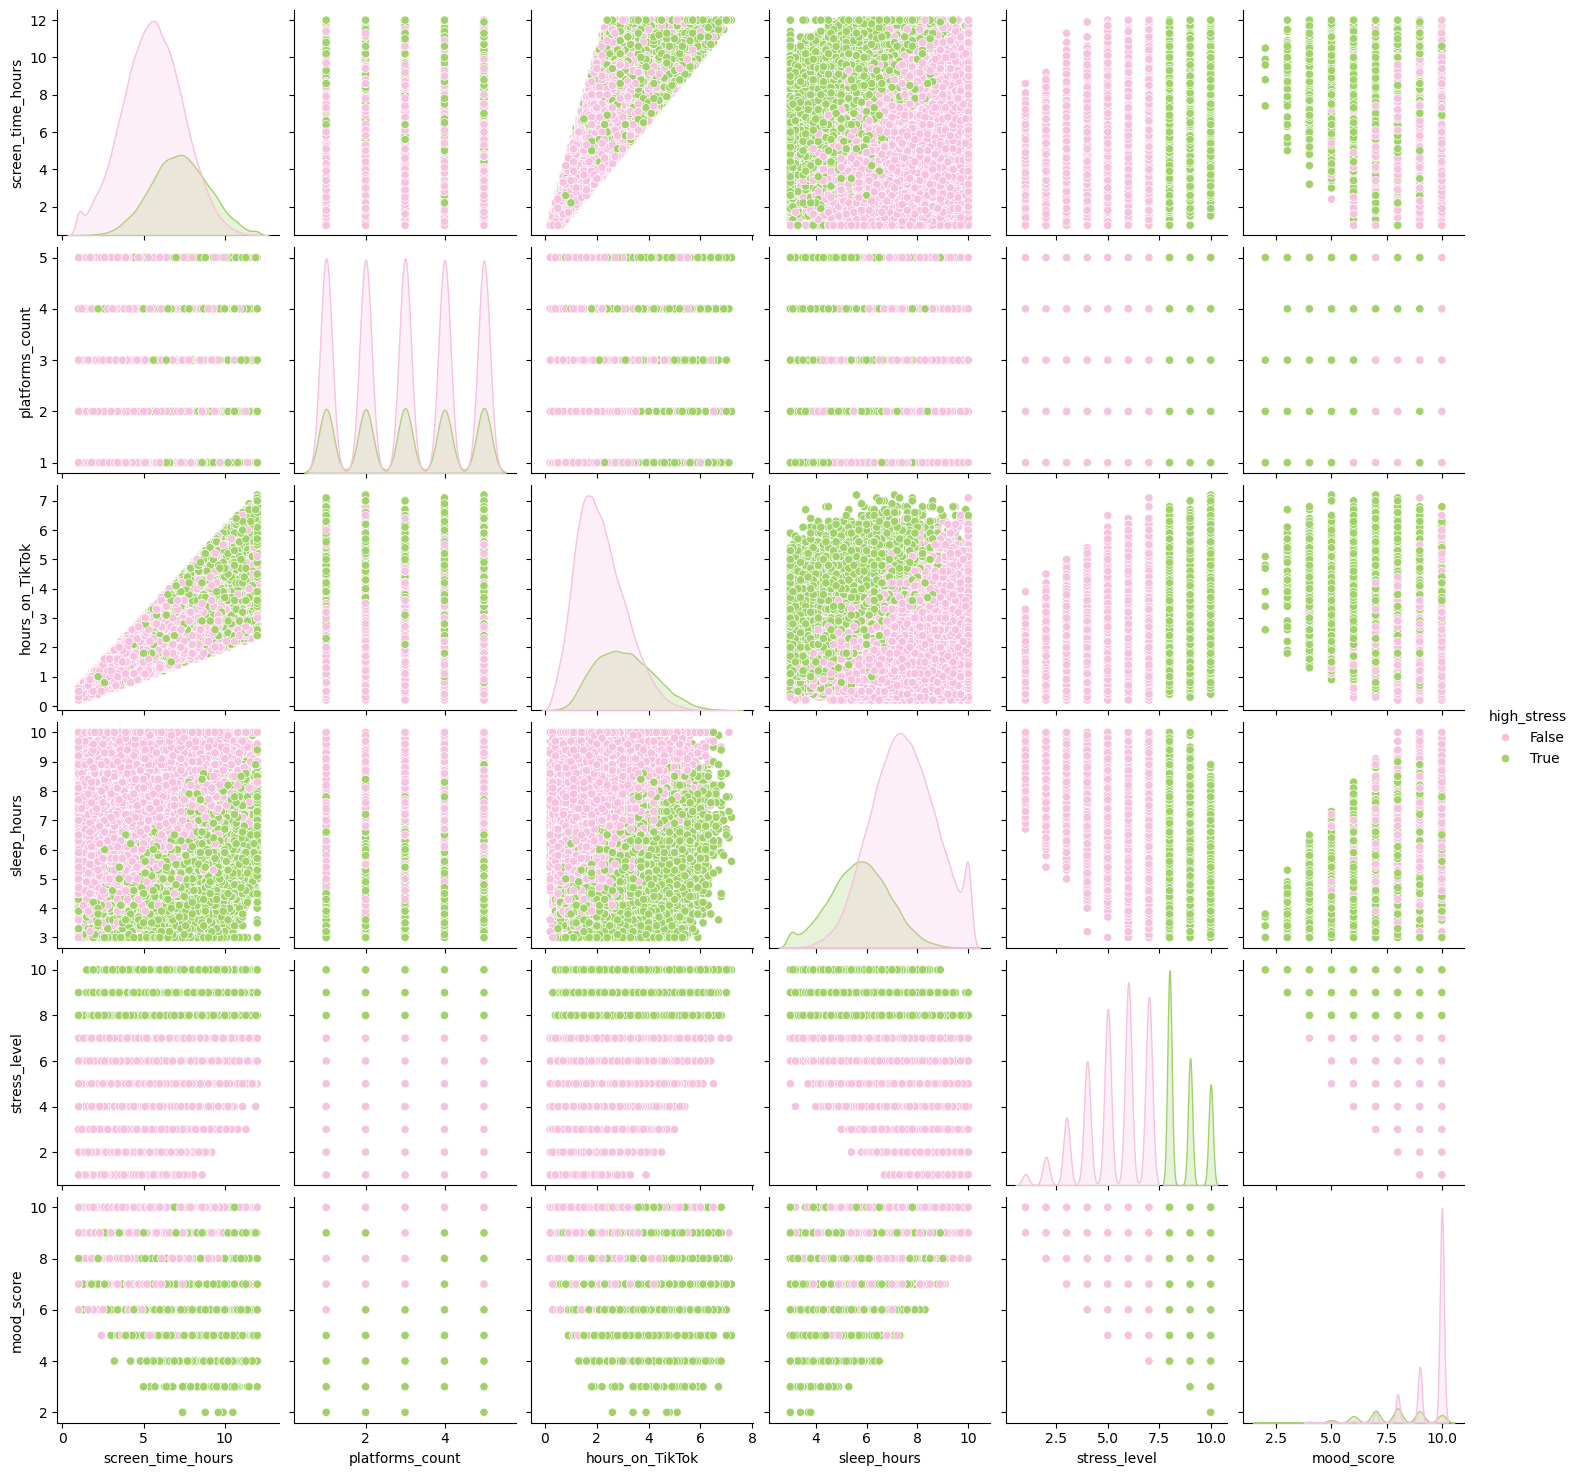

In [18]:
palette = ["#f5c2e0", "#a1d26a"]  # pink = low, grün = high

sns.pairplot(
    df,
    hue="high_stress",
    palette=palette
)

<b>Kurzinterpretation: </b> Die farblichen Trennungen veranschaulichen, dass `sleep_hours`, `hours_on_TikTok`, `screen_time_hours` und `mood_score` klare Unterschiede zwischen `high_stress=True` und `high_stress=Flase` aufweisen.
`platforms_count` ist als Prädiktor schwach.

Diese Muster wirken klar verteilt und passen zu künstlich generierten Daten mit einfachen Abhängigkeiten.

***
### 2.4 Interpretation / Empfehlung zu Feature Engineering


#### 2.4.1 Klassenverteilung


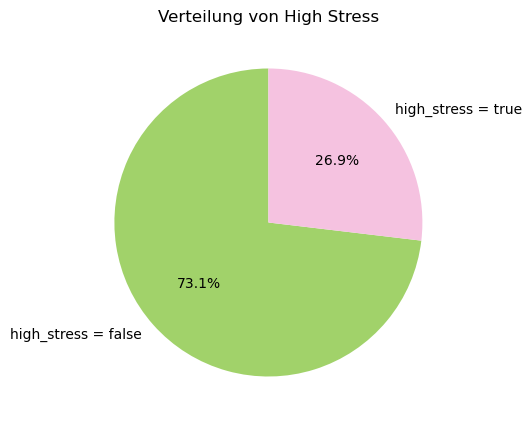

In [19]:
# Zähle die Häufigkeiten von True und False
counts = df['high_stress'].value_counts()

colors = ['#a1d26a',  # softes Grün
          '#f5c2e0']  # softes Pink


# Visualisierung als Tortendiagramm
plt.figure(figsize=(5, 5))
plt.pie(
    counts,
    #labels=['High Stress (False)', 'High Stress (True)'],
    labels=['high_stress = false', 'high_stress = true'],
    colors=colors,
    autopct='%1.1f%%',
    startangle=90,
)
plt.title('Verteilung von High Stress')
#plt.savefig("klassenverteilung.png", dpi=300, bbox_inches="tight")
plt.show()

<b>Kurzinterpretation:</b> Die Klassenverteilung ist mit 73,1% in der Mehrheitsklasse (Low Stress) zu 26,9% in der Minderheitsklasse (High Stress) deutlich unausgeglichen, was zu Verzerrungen führen kann. Ein <b>Class Imbalance</b> kann z.B. dazu führen, dass die Accuracy des Models falsch bewertet wird, ebenso wie der Recall-Rate (Sensitivität) für High-Stress-Werte. Mit unbalancierten Klassen trainierte Modelle tendieren außerdem dazu Vorhersagen zu Gunsten der größeren Klasse zu treffen.

Besonders in Datensätzen aus dem Bereich medizinischer Anwendungen und Kognitionswissenschaften treten Klassenungleichgewichte häufig auf, da Beobachtungen mit einer positiven Zielvariable (bsp. Auftreten einer Krankheit) seltener vorkommen. 
(Krawczyk, B. Learning from imbalanced data: open challenges and future directions. Prog Artif Intell 5, 221–232 (2016). <url>https://doi.org/10.1007/s13748-016-0094-0</url>)

<b>Umgang mit Klassenungleichgewicht:</b>
Sollte ein sehr deutliches Klassenungleichgewicht vorliegt, können in Bereichen wo die Kosten für False Negatives sehr hoch sind, diese Strategien genutzt werden:

- Senken des Schwellenwerts für `high_stress`
- Anpassen des Klassengewichts mit `LogisticRegression(class_weight="balanced")`
- Undersampling (Entfernen von Datensätzen mit `high_stress = false `)
- Oversampling (Generieren von Datensätzen mit `high_stress = true` z.B. mit Duplikaten oder SMOTE)
- Balanced Accuracy (`BAcc` wie hier empfohlem <url>https://www.sciencedirect.com/science/article/pii/S1053811923004044</url> )

Im Folgenden wurde der SciKit-Learn Parameter `class_weight="balanced"` gesetzt. Für XGBoost wird `scale_pos_weight =n_target_false / n_target_true` gesetzt, das funktional äquivalent zum vorherigen ist.

In [20]:
# Beispielcode für SMOTE (Synthetic Minority Oversampling Technique)

# from imblearn.over_sampling import SMOTE
# X_res, y_res = SMOTE().fit_resample(X, y)

***
#### 2.4.2 Missing Values


In [21]:
# Zählt summe fehlender Werte
print(df.isnull().sum())

screen_time_hours    0
platforms_count      0
hours_on_TikTok      0
sleep_hours          0
stress_level         0
mood_score           0
high_stress          0
dtype: int64


<b>Kurzinterpretation:</b> Das Dataset enthält keine Missing Values.


<b>Umgang mit Missing Values:</b>

Es gibt drei Arten fehlender Werten:
<ul> 
<li><b>MAR - Missing at random:</b> Fehlen korreliert mit min einer Variablen</li>
<li><b>MCAR - Missing completely at random:</b> Bsp Sensor fällt aus</li>
<li><b>MNAR - Missing not at random:</b> Fehlende Variable korreliert mit Fehlen (plus evtl. zusätzlichen Variablen)</li>
</ul>
<br>
<b>Annahme:</b> Es liegen MCAR Missing Values vor.
Da das Dataset 100.000 Einträge umfasst, wäre `df.dropna()`, also Listwise Deletion die Strategie meiner Wahl - zumindest bei bis zu ca. 10% fehlenden Werten. Bei mehr als 10.000 fehlenden Werten in einer Spalte würde ich eine <b>Imputation</b> vorschlagen

<b>Ablauf Imputation:</b>
- Immer Daten zu erste in Train- and Testsets splitten um Data Leakage zu vermeiden!
- Anschließen zuerst Trainingsdaten mit fit() fitten
- Dann Testdaten mit fit_transform() fitten

Im Folgenden wird die Imputation mit `SimpleImputer(strategy="median")` für numerische Variablen und `SimpleImputer(strategy="most-frequent")` für kategoriale Variablen verwendet.

***
#### 2.4.3 Encoding

<b>Kurze Begründung:</b>Es ist prinzipiell kein Encoding nötig, da die Eingangsvariablen keine nominalen oder ordinalen Daten ohne gleichmäßige Abstände (z.B. Likert-Skalen) sind.


Es wurden vier Kodierungsverfahren besprochen:
<ul> 
<li><b>One-Hot:</b> robust, aber hohe Dimensionalität - ideal bei Baummodellen wie DT, RF, XGB</li>
<li><b>Dummy:</b> gut für lineare Modelle, vermeidet Korrelation</li>
<li><b>Ordinal:</b> nutzt Ranginformation, kann aber falsche Abstände erzeugen</li>
<li><b>Target:</b> auch für Baummodelle, bei hoher Kardinalität (mit Glättung o. Hashing), informationsreich, aber Leakage-Gefahr</li>
</ul>
<br>

Im Folgen wird nach Best Practices für Baummodelle OneHotEncoding verwendet. Die Encoder sind in Pipelines immer nach(!) Train/Test-Split zu fitten



In [22]:
# Beispielcode für OneHotEncoding

# encoder = OneHotEncoder(handle_unknown=”ignore”)
# X_train = encoder.fit_transform(X_train)
# X_test = encoder.transform(X_test)

***
#### 2.4.4 Skalierung

<b>Kurze Begründung:</b> Ich verzichte bewusst auf eine Skalierung der Merkmale, da alle Eingangsvariablen bereits in vergleichbaren Skalenbereichen liegen und eine zusätzliche Standardisierung keinen erkennbaren Mehrwert für das Modell bietet. Sollte dies nicht der Fall sein, wäre für die Logistische Regression unbedingt notwendig.

Verfahren, die dann zum Skalieren in Frage kommen sind:
<ul>
<li><b>Z-Score / Standardisierung:</b> erzeugt symmetrische Verteilung durch verschieben und skalieren</li>
<li><b>Robuste Skalierung:</b> gut geeignet bei Ausreißern, aber verliert ggf Dynamik</li>
<li><b>Min-Max-Scaling:</b> Form der Daten bleibt bestehen, Range ändert sich, empflindlich bei Ausreißern</li>
<li><b>L2-Normierung/Vektornorm</b></li>
</ul>

Besonders Min-Max-Skaling ist für logistische Regression geeignet, da Werte anschließend in einem festgelegten Bereich z.B. 0...1 liegen. 

Im Folgenden wird StandardScaler() verwendet.

In [23]:
# Beispielcode für den Standardskalierer / z-Score:

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test  = scaler.transform(X_test)

Werte werden damit um den Ursprung als Mittelwert mit einer Standardabweichung von 1 skaliert

In [24]:
# Alternativ der Beispielcode für den MinMaxScaler:

# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

Der Featurerange liegt damit im Bereich -1 und +1, 
kann aber über mit 
scaler = MinMaxScaler(feature_range=(0, 10))
auch angepasst werden. Diese Werte würde ich wählen, da sie bereits einem Großteil der Daten zugrunde liegen



*** 
## 3. Preprocessing
Anm.: Obwohl keine `cat_features` im Datensatz enthalten sind und keine Missing Values vorliegen, wird die korrekte Behandlung nach best Practices mit Encoding und Imputation druchgeführt .

### 3.1 Train/Test Split 
Vor Skalierung und Imputation durchführen

In [25]:
# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, stratify=y, random_state=42)

In [26]:
X_train.shape, X_test.shape

((80000, 4), (20000, 4))

### 3.2 Pipelines

In [27]:
# Pipeline Dummies, da cat_features leer ist

# Pipeline für numerische Spalten 
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy = 'mean')),
    ("scaler", StandardScaler())
    ])

# Pipeline für kategoriale Spalten 
cat_tranfsformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most-frequent")),
    ("encoder", OneHotEncoder(handle_unknown = "ignore"))
    ])
                    
preprocessor = ColumnTransformer(transformers = [
    ("num", num_transformer, num_features),
    ("cat", cat_tranfsformer, cat_features)  
])

## 4. Model Training
Im verwendeten Datensatz tritt nur ein geringer Umfang von Features auf. Davon sind nur zwei ordinal-skaliert.
Für die Vergleichmodelle wird daher als Ausgangmodell ein einfaches lineares Modell (Logistische Regression) gewählt, sowie zwei baumbasierte Modelle (Random Forrest und XGBoost), die komplexe Zusammenhänge erfassen.

Dadurch können einmal das lineare Modell mit der Performanceunterschiede zwischen Bagging und Boosting verglichen werden.


### 4.1 Modell 1: Logistische Regression
Kurzinfo: Die logistische Regression ist gut interpretierbar und bildet das linearer Vergleichsmodell. Sie ist regularisationsbasiert.

In [28]:
# Modell Pipeline

pipe_lr = Pipeline(
    steps = [
        ("pre", preprocessor), 
        ("clf", LogisticRegression(
            max_iter = 1000, 
            class_weight = "balanced"
        ))
    ]
)
# max_iter: Max. Iterations des Optimierungsalgorithmus bis Konvergenz erreicht sein muss
# class_weight="balanced" gewichtet bestehende Klassen so, dass sie balanciert sind. Ist hier eigentlich redundant

***
### 4.2 Modell 2: Random Forrest
Erfasst Nichtlinearitäten, ist robust und zeigt Feature Importance. RF erlaubt es, komplexe Zusammenhänge zwischen Nutzungsverhalten und Schlaf abzubilden, die LogReg nicht erfassen kann.

Random Forest trainiert als ensemble-basiertes Modell parallel mehrere (schwache) Decision-Trees, denen einfach interpretierbare Conditionals zugrunde liegen. Aus dem Mittelwert bildet er ein starken Modell. Das sog. Bagging / Bootstrap-Aggregation reduziert die Varianz durch diese Mittelung. Randomisierung ermöglicht Dekorrelation und Stabilisierung. Dieses Verfahren stellt eine aus drei Wegen zur Generalisierung im ML dar.


In [29]:
pipe_rf = Pipeline(
    steps = [
        ("pre", preprocessor), 
        ("clf", RandomForestClassifier(
            n_estimators = 200, 
            class_weight= "balanced", 
            random_state=42
        ))
    ]
)
# n_estimators: Anzahl der Entscheidungsbäume im Forest
# random_state: Seed für Zufallszahlengenerator

***
### 4.3 Modell 3: XGBoost
Kurz für: eXtreme Gradient Boosting. Es handelt sich ebenfalls um eine quelloffene Machine Learning Bibliothek. Es handelt sich um ein Ensemblemodell, das gradientgeboostete Entscheidungsbäume verwendet. Besonders hervorzuheben sind die Geschwindigkeit, die Effizient und die gute Skalierbarkeit des Modells auf große Datensätzen.

Im Gegensatz zu RF nutzt es Boosting statt Bagging. Durch Boosting können sequentiell frühere Fehler korrigiert werden, wodurch sich der Bias verringert. Jeder neue Baum korrigiert die Fehler des vorherigen.

In [30]:
# Workaround für class imbalance
n_target_false = np.sum(y == 0)
n_target_true  = np.sum(y == 1)

pipe_xgb = Pipeline(
    steps = [
        ("pre", preprocessor), 
        ("clf", xgb(
            eval_metric = "logloss", 
            random_state=42, 
            verbosity = 1,
            scale_pos_weight = n_target_false / n_target_true # funktional äquivalent zu class_weight="balanced"
        ))
    ]
)
# eval_metric: legt Metrik zu Bewertung im Training fest -> log. Verlust, gut für Klassifikationsproblemen
# verbosity: 1 = warning. Steuert Ausgabe von Warnungen während des Trainings. 0=silent, 2=info, 3=debug

In [31]:
# Models Dictionary
models = {"LogisticRegression": pipe_lr, "RandomForest": pipe_rf, "XGBoost": pipe_xgb}

****
### 4.4 Hyperparameter-Tuning & Trainingsdauer
Mit GridSearchCV

#### 4.4.1 Grids mit Parametern anlegen

In [32]:
lr_grid = {
    "clf__C": [0.1, 1.0, 10.0],
    "clf__penalty": ["l2"],
    "clf__solver": ["lbfgs"]   
}

# C ist Regularisierungsstärke, sie steuert wie stark Modellgewichte bestraft werden
# penalty: "l2" ist default, "l1": mit saga, "none": ist auch möglich, "elasticnet": adds l1 and l2
# solver: "lbfgs" ist default-> funktioniert nicht mit "l1", "liblinear" gut für kleine Datensätze, "saga" für große Datensätze
# opt. class_weight, max_iter, aber die gebe ich beim Aufruf von GridSearchCV an

rf_grid = {
    "clf__n_estimators": [100],
    "clf__max_depth": [None, 10],
    "clf__min_samples_leaf": [1, 5]
}
# n_estimators: Anzahl Bäume die "gebaggt" werden. default=100. Können auch mehrere Werte sein, wg. zu langer LZ reduziert
# min_samples_leaf: Splits sind nur berücksichtigt, wenn min diese Anzahl Samples am Knoten hängt.
# Hohe Anzahl Samples  -> weniger Tiefe, weniger Overfitting
# criterion: {"gini", "entropy", "log_loss"} - default = "gini" - misst Qualität der Splits
# max_depth: maximale Tiefe des Baums, default = "None"
# bootstrap: default = true

xgb_grid = {
    "clf__n_estimators": [100, 200, 300],
    "clf__max_depth":[3, 5, 7],
    "clf__learning_rate": [0.01, 0.1, 0.3]  
}
# learning rate: niedrige Lernrate (0.01-0.1) -> gute Generalisierung, nur kleine Korrekturen jedes mal deshalb mehr Bäume nötig
# hohe Lernrate(ab 0.3) -> einzelne Bäume haben großen Einfluss, dadurch schnelles Lernen & weniger Bäume, aber Overfitting-Gefahr

#### 4.4.2 Modelle trainieren + Hyperparameter-Tuning

In [33]:
param_grids = { "LogisticRegression": lr_grid, 
               "RandomForest": rf_grid, 
               "XGBoost": xgb_grid 
              }

best_estimators = {}
train_times = {}

for name, pipe in models.items():
    print(f"Tuning & Training: {name}")

    grid = GridSearchCV(
        pipe,
        param_grids[name],
        scoring="f1",
        cv=5,
        n_jobs=1
    )

# scoring="f1" nutzt F1-Score zur Auswahl des besten Modells
# cv=5 Cross Validation mit 5 Folds, Trainingsdaten werden in 5 Teile geteilt und Training wird 5x durchgeführt (1x Validierungs-Condition)
# n_jobs: Anzahl CPU Kerne. -1 bedeutet alle Kerne, beschleunigt Training, aber führt womöglich zu Memory Leaks o. Timeouts, insb. beim Hyperparameter Tuning
# n_jobs=1 -> keine Parallelisierung, nur 1 Kern

 # Dauer des Tunings messen
    start = time.time()       
    grid.fit(X_train, y_train)
    end = time.time()    

    train_times[name] = end - start
    best_estimators[name] = grid.best_estimator_

    print(f"Beste Parameter: {grid.best_params_}")
    print(f"Dauer: {train_times[name]:.2f} Sekunden\n")

print("Alle Modelle fertig.\n")

for name, duration in train_times.items():
    print(f"{name} dauerte: {duration:.2f} s")

Tuning & Training: LogisticRegression
Beste Parameter: {'clf__C': 10.0, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Dauer: 0.58 Sekunden

Tuning & Training: RandomForest
Beste Parameter: {'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 100}
Dauer: 43.59 Sekunden

Tuning & Training: XGBoost
Beste Parameter: {'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 200}
Dauer: 13.95 Sekunden

Alle Modelle fertig.

LogisticRegression dauerte: 0.58 s
RandomForest dauerte: 43.59 s
XGBoost dauerte: 13.95 s


In [34]:
# Reine Trainingzeit messen
final_models = {}
final_train_times = {}

for name, est in best_estimators.items():
    print(f"Finales Training: {name}")

    start = time.time()
    est.fit(X_train, y_train)
    end = time.time()

    final_models[name] = est
    final_train_times[name] = end - start

    print(f"Trainingsdauer (final): {final_train_times[name]:.2f} Sekunden\n")


Finales Training: LogisticRegression
Trainingsdauer (final): 0.07 Sekunden

Finales Training: RandomForest
Trainingsdauer (final): 2.34 Sekunden

Finales Training: XGBoost
Trainingsdauer (final): 0.07 Sekunden



***
### 5. Evaluation

#### Hilfsfunktion zur Evaluation
<i> Quelle: MLL_Woche07_02.ipynb</i>
<br><br>
Hinzugefügt: 
- Overfitting Analyse durch Vergleich der Accuracy von Trainings- gegen Testdaten
- PR-AUC
- ROC- und PR-Kurven
- Baum-Visualisierung
- SHAP


In [43]:
def evaluate_model(name, clf, X_train, y_train, X_test, y_test):
    # Vorhersage der Klasse
    y_pred = clf.predict(X_test)
    
    # Für ROC-AUC: Wahrscheinlichkeiten, falls verfügbar
    if hasattr(clf, "predict_proba"):
        y_proba = clf.predict_proba(X_test)[:, 1]  # Wahrscheinlichkeit für Klasse 1 (hoher Stress)
        roc_auc = roc_auc_score(y_test, y_proba)
        pr_auc = average_precision_score(y_test, y_proba)
        precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba)
    else:
        roc_auc = np.nan   
        pr_auc = np.nan 
        precision_curve, recall_curve = None, None    
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

     # Overfitting-Analyse                               
    y_pred_train = clf.predict(X_train)                                          
    acc_train = accuracy_score(y_train, y_pred_train)                            
    f1_train = f1_score(y_train, y_pred_train, zero_division=0)                  

    print(f"=== {name} ===")
    print(f"Accuracy : {acc:.3f}")
                                                   
    print(f"Accuracy Train/Test Δ: {acc_train:.3f} / {acc:.3f} (Δ {acc_train-acc:.3f})")  
    print(f"Precision: {prec:.3f}  (bezogen auf Klasse 'high_stress = 1')")
    print(f"Recall   : {rec:.3f}  (Sensitivität für 'high_stress = 1')")
    print(f"F1-Score : {f1:.3f}")                                                       
    print(f"F1-Score Train/Test Δ: {f1_train:.3f} / {f1:.3f} (Δ {f1_train-f1:.3f})")    
    print(f"ROC-AUC  : {roc_auc:.3f}")
    print(f"PR-AUC   : {pr_auc:.3f}")      
    print()
    

   # Plot Confusion Matrix

    #Color Map erstellen
    pink_green = LinearSegmentedColormap.from_list("PinkGreen",
    ["#f5c2e0", "#a1d26a"])
    
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(
        cm, 
        display_labels=["high_stress=0", "high_stress=1"]
        )
    disp.plot(values_format="d", cmap=pink_green )
    
    # Zahlen schwarz färben
    for text in disp.text_.ravel():
        text.set_color("black")
    plt.title(f"{name}")
    #plt.savefig(f"ConfusionMatrix-{name}.png", dpi=300, bbox_inches="tight")
    plt.show()
    

    # N ROC-Curve (wenn Wahrscheinlichkeiten vorhanden)
    #if hasattr(clf, "predict_proba") and y_proba is not None:                       
        #fpr, tpr, _ = roc_curve(y_test, y_proba)                                    
        #plt.plot(fpr, tpr)
        #plt.xlabel("False Positive Rate")
        #plt.ylabel("True Positive Rate")
        #plt.title(f"ROC Curve – {name}")
        #plt.grid()
        #plt.show()

    # Precision-Recall Curve
    plt.plot(recall_curve, precision_curve)                                     
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve – {name}")
    plt.grid()
    plt.show()

    # SHAP
    X_sample = X_train[:1000]

    # Pipeline teilen
    X_trans = clf.named_steps["pre"].transform(X_sample)
    model = clf.named_steps["clf"]
        
    # Feature-Namen extrahieren
    raw_feature_names = clf.named_steps["pre"].get_feature_names_out()
    feature_names = [
        name.split("__")[-1] for name in raw_feature_names
    ]

    
    if name == "LogisticRegression":
        explainer = shap.LinearExplainer(model, X_trans)
    else:
        explainer = shap.TreeExplainer(model)

    shap_values = explainer.shap_values(X_trans)

    # Fall 1:  RF
    if isinstance(shap_values, list):
        shap_values = shap_values[1]   # Klasse 1 = high_stress

    # Fall 2: 3D array (n_samples, n_features, n_classes)
    shap_values = np.array(shap_values)
    if shap_values.ndim == 3:
        shap_values = shap_values[:, :, 1]  # Klasse 1 statt sum(axis=-1)

    shap.summary_plot(
        shap_values,
        X_trans,
        feature_names=feature_names,
        cmap=pink_green,
        show=True       # auf False setzen fürs Speichern des .png!
    )

    plt.title(f"{name}")
    plt.tight_layout()
    #plt.savefig(f"shap_s{name}.png", bbox_inches="tight")
    plt.close()

      

#### 5.1 Evaluation mit Hilfsfunktion 

=== LogisticRegression ===
Accuracy : 0.847
Accuracy Train/Test Δ: 0.850 / 0.847 (Δ 0.003)
Precision: 0.667  (bezogen auf Klasse 'high_stress = 1')
Recall   : 0.864  (Sensitivität für 'high_stress = 1')
F1-Score : 0.753
F1-Score Train/Test Δ: 0.757 / 0.753 (Δ 0.004)
ROC-AUC  : 0.934
PR-AUC   : 0.852



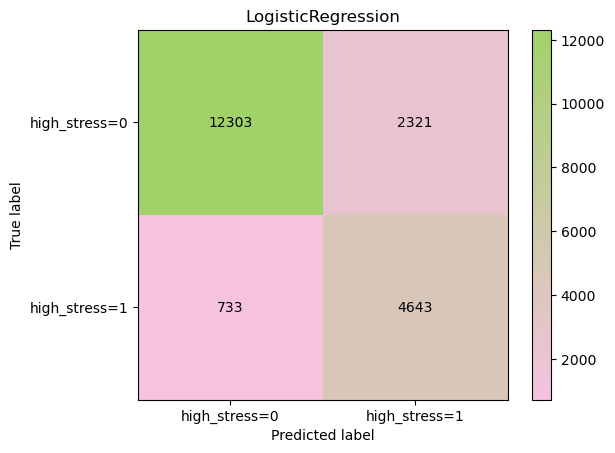

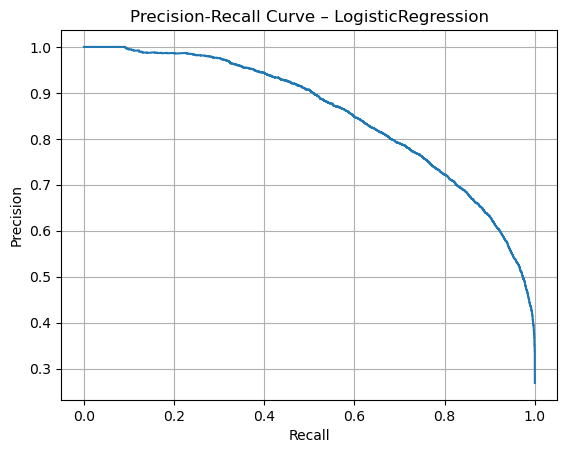

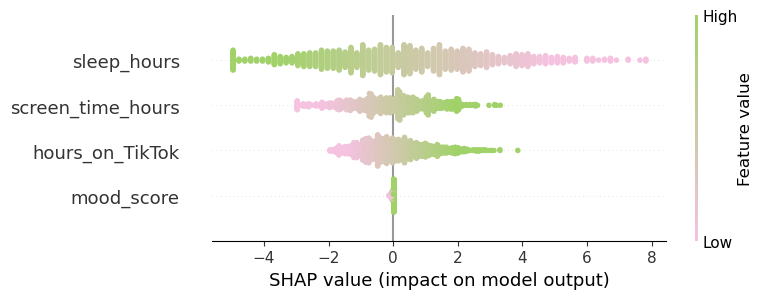

=== RandomForest ===
Accuracy : 0.846
Accuracy Train/Test Δ: 0.861 / 0.846 (Δ 0.015)
Precision: 0.665  (bezogen auf Klasse 'high_stress = 1')
Recall   : 0.861  (Sensitivität für 'high_stress = 1')
F1-Score : 0.750
F1-Score Train/Test Δ: 0.774 / 0.750 (Δ 0.024)
ROC-AUC  : 0.932
PR-AUC   : 0.848



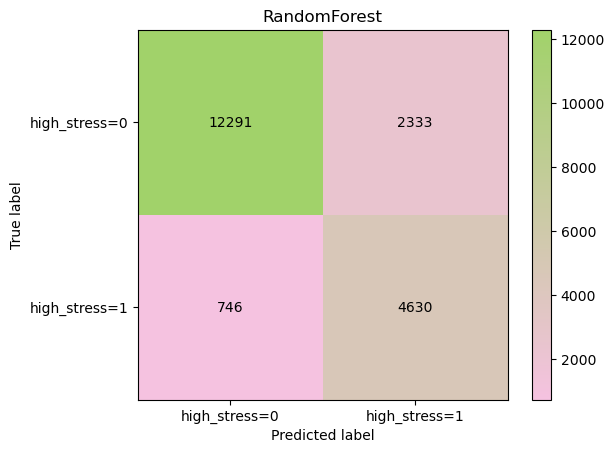

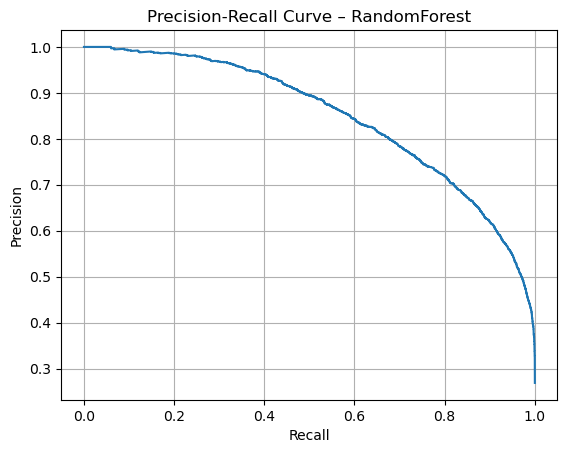

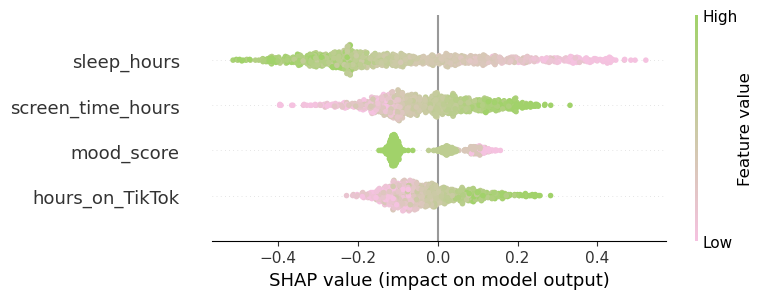

=== XGBoost ===
Accuracy : 0.842
Accuracy Train/Test Δ: 0.847 / 0.842 (Δ 0.005)
Precision: 0.656  (bezogen auf Klasse 'high_stress = 1')
Recall   : 0.871  (Sensitivität für 'high_stress = 1')
F1-Score : 0.748
F1-Score Train/Test Δ: 0.755 / 0.748 (Δ 0.007)
ROC-AUC  : 0.934
PR-AUC   : 0.851



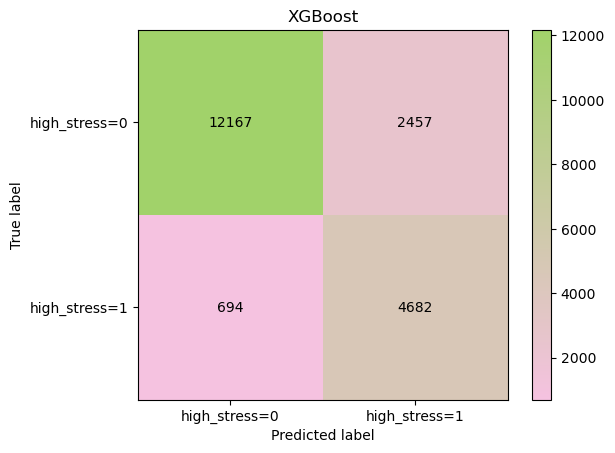

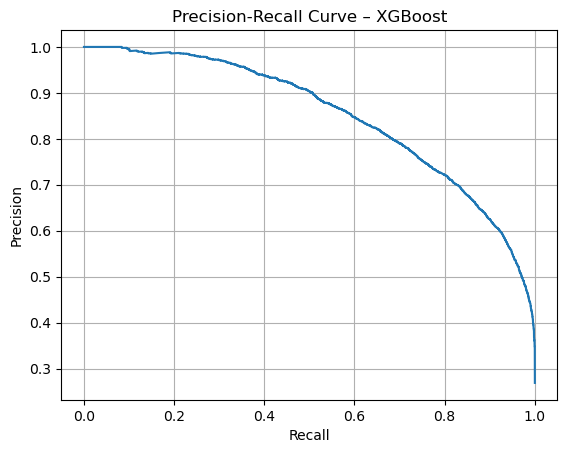

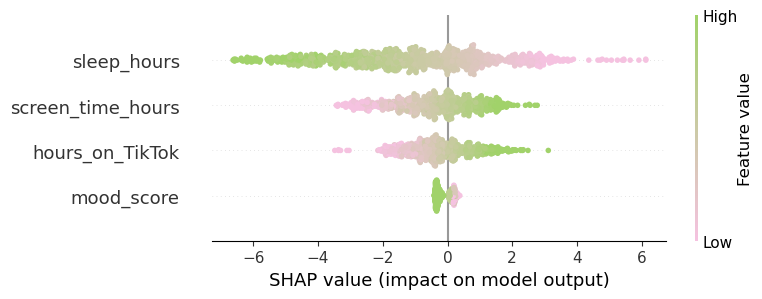

In [44]:
for name, clf in best_estimators.items():
    evaluate_model(name, clf, X_train, y_train, X_test, y_test)


#### 5.2 ROC-Plot für alle Modelle

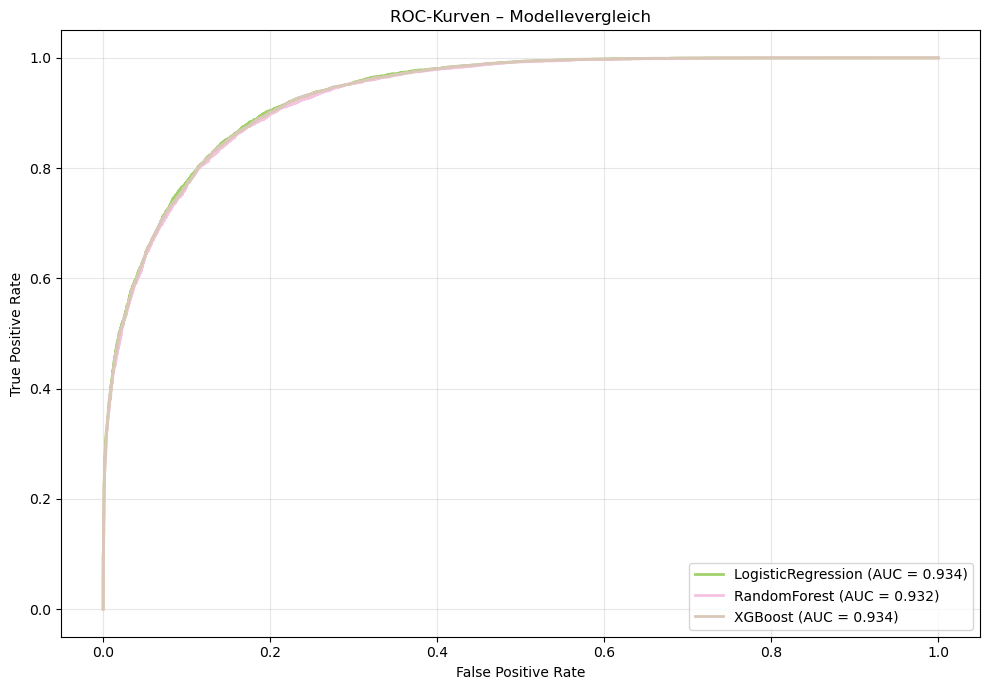

In [37]:
model_colors = {
    "LogisticRegression": "#a1d26a",  # grün
    "RandomForest": "#f5c2e0",         # pink
    "XGBoost": "#d9c7b8"                # beige
}

plt.figure(figsize=(10, 7))

for name, model in final_models.items():

    # Scores für ROC bestimmen
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
    else:
        y_score = model.predict(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(
        fpr,
        tpr,
        linewidth=2,
        color=model_colors[name],
        label=f"{name} (AUC = {roc_auc:.3f})"
    )


plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-Kurven – Modellevergleich")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
#plt.savefig(f"ROC-Kurven.png", dpi=300, bbox_inches="tight")
plt.show()


#### 5.3 Baum-Visualisierung

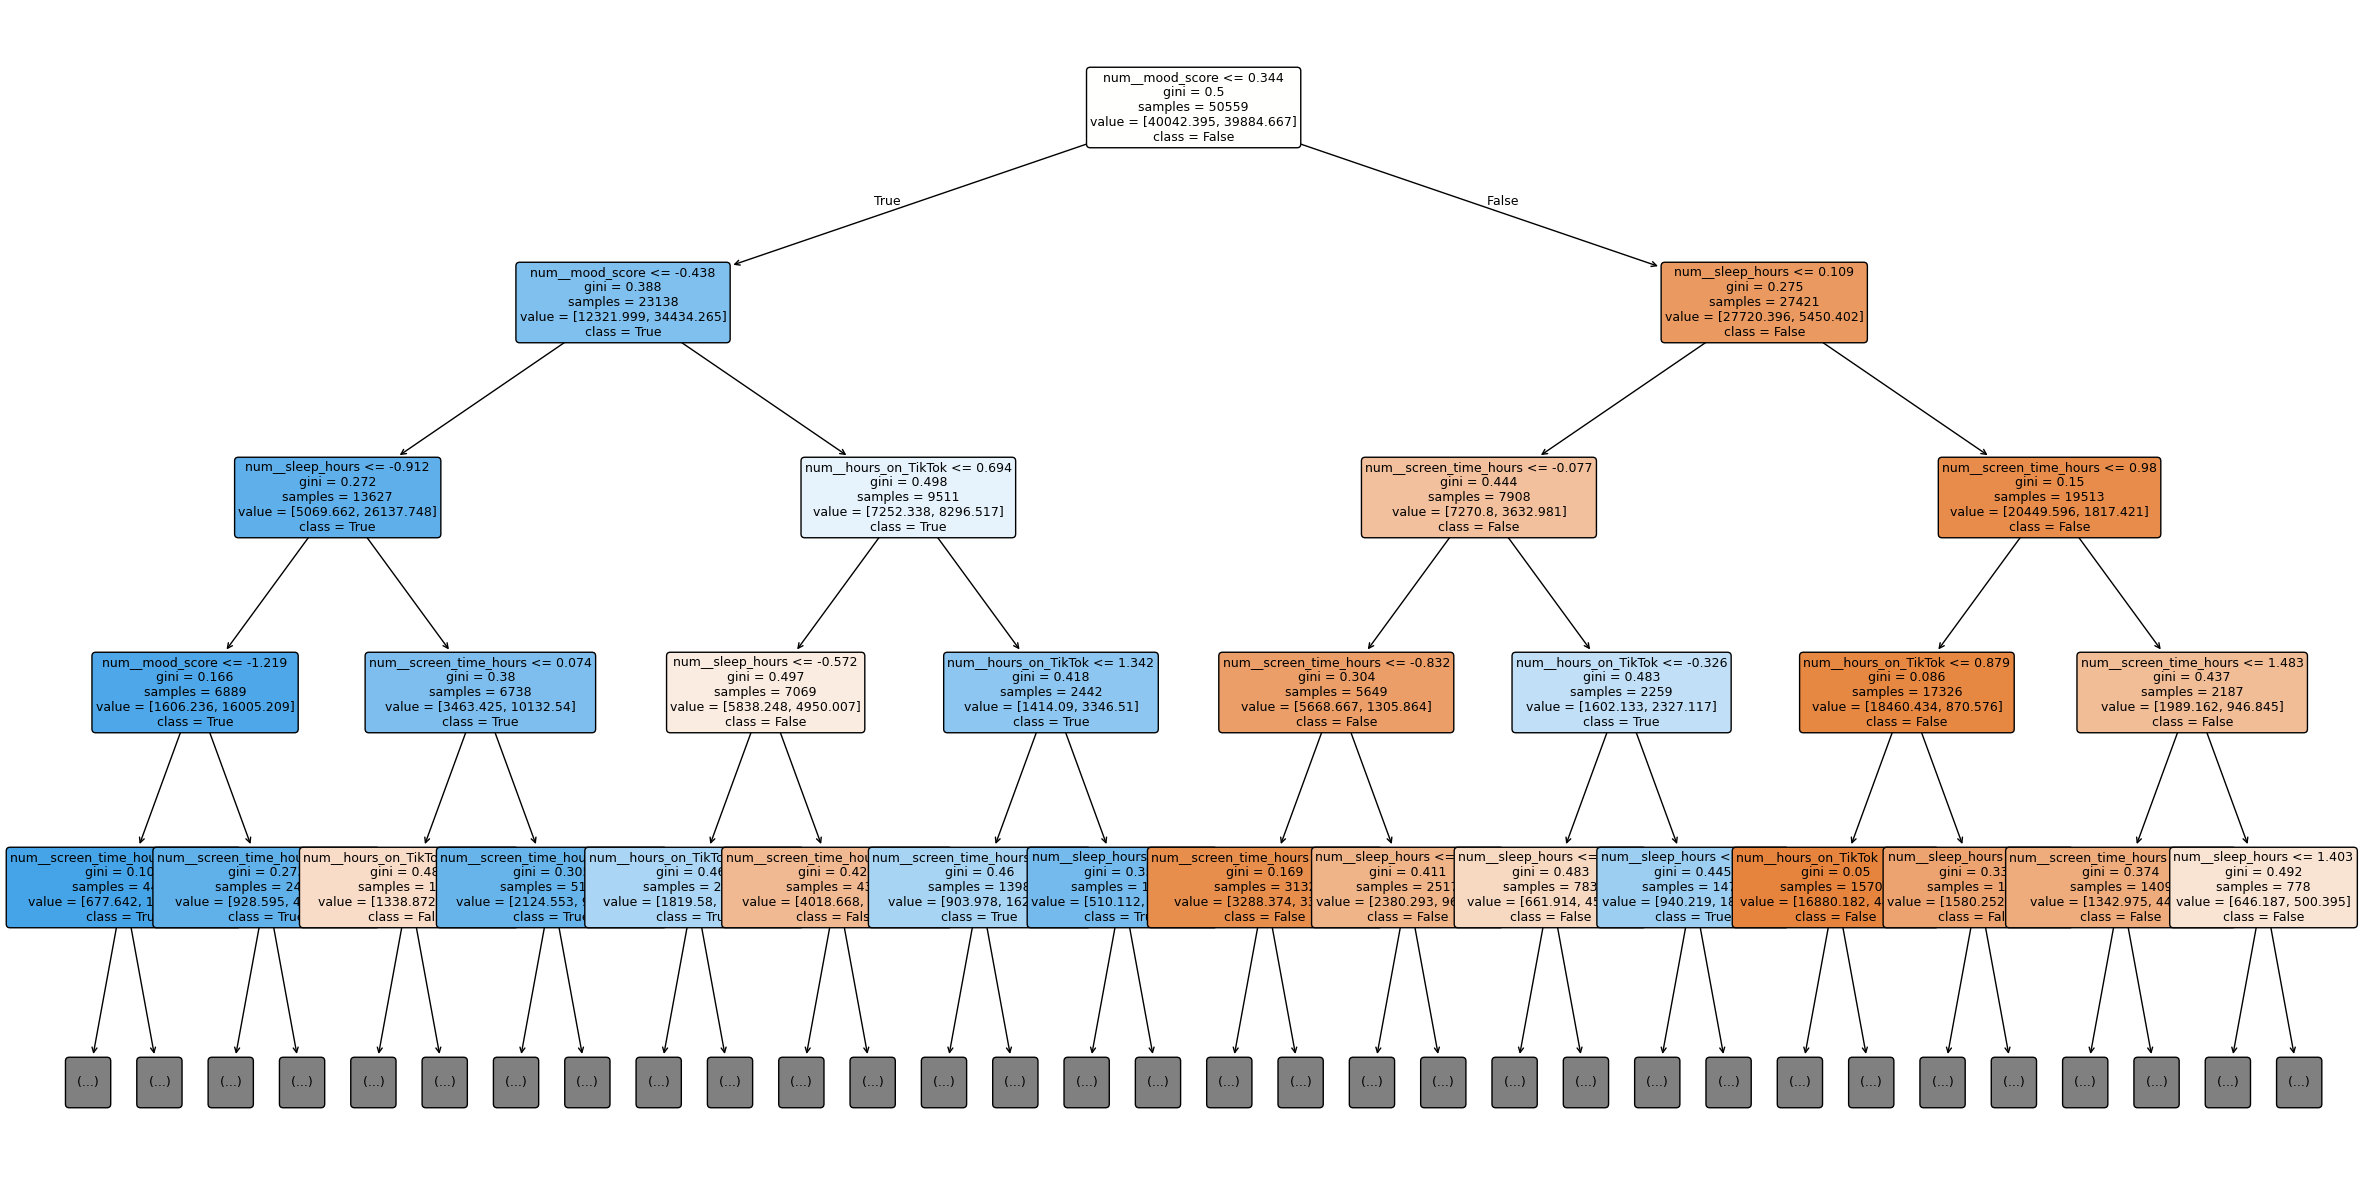

In [38]:
# Random Forest

# Feature-Namen exportieren
rf_pipe = best_estimators["RandomForest"] 

feature_names = rf_pipe.named_steps["pre"].get_feature_names_out()
rf = rf_pipe.named_steps["clf"]

# Baum in [0] auswählen
tree = rf.estimators_[0]


# Plotten (max_depth begrenzen, sonst unlesbar)
plt.figure(figsize=(24, 12))
plot_tree(
    tree,
    feature_names=feature_names,
    class_names=["False", "True"],
    filled=True,
    rounded=True,
    max_depth=4,
    fontsize=9
)
plt.tight_layout()
plt.show()

In [40]:
# TODO: XGBoost Plotten

***
## 6. Interpretation 
Die verwendeten Klassifikationsmetriken wurden wie folgend erhoben:
- <b>Accuracy</b> prozentualer Anteil korrekt vorhergesagter Klassifikationen (TN + TP aus allen Vorhersagen)
- <b>Precision</b> prozentualer Anteil korrekt vorhergesagter Positiver aus allen positiv klassifizierten (TP / (TP +  FP))
- <b>Recall / Sensitivität</b>  prozentualer Anteil korrekt vorhergesagter Positiver, aus allen tatsächlich Positiven (TP / (TP + FN))
- <b>F1- Score</b> (Precision + Recall) / (Precision * Recall)
- <b>ROC-AUC</b>
- <b>PR-AUC</b>


### 6.1 Accuracy
Durch die Anwendung des Parameters `class_weight="balanced"` bzw. `scale_pos_weight` kann die Accuracy korrekt interpretiert werden. Ein ausgeprägtes Klassenungleichgewicht würde ein Bias in Richtung der Mehrheitsklasse begünstigen.
Die Werte liegen zwischen 84.2% und 84.7% korrekter Vorhersagen. Fast kein Unterschied.

| Metrik | Logistic Regression | Random Forest | XGBoost |
| --- | --- | --- | --- |
| Accuracy | 0.847 | 0.846 | 0.842 |


### 6.2 Precision, Recall, F1-Score


| Metrik | Logistic Regression | Random Forest | XGBoost |
| --- | --- | --- | --- |
| Precision (`high_stress=1`)| 0.667 | 0.665 | 0.656 |
| Recall (`high_stress=1`)| 0.864 | 0.861 | 0.871 |
| F1-Score | 0.753 | 0.750 | 0.748 |


XGBoost beweist die höchste Precision, die Logistische Regression den höchster Recall. Der <b>Precision</b> liegt bei LR und RF auf 66.7% bzw. 66.5%, XGBoost weist mit 65.6% eine marginal niedrigere Präzision vor.
Der <b>Recall</b> von 86.1% bis 87.1% zeigt, dass alle Modelle knapp 15% aller Hochstress-Fälle übersehen. 
Eine korrekte Klassifikation von positiven Hochstress-Fälle ist im  Kontext mentaler Gesundheit sehr relevant erscheint, um beispielsweise Präventionsmöglichkeiten sinnvoll anzubieten. 

Die <b>F1-Werte</b> liegen bei allen Modellen um 75%. Es besteht kein signifikanter Unterschied. Die Ergebnisse sind gut, aber nicht perfekt.

Die Kosten für False Negatives sind im Kontext der mentalen Gesundheit von vulnerablen Gruppen wie Jugendlichen höher zu bewerten, als die Kosten für False Positives. Ein höherer Recall, selbst auf Kosten der Präzision ist deshalb zu bevorzugen. 

### 6.3 ROC-AUC und PR-AUC

Die Reciever Operating Curve (ROC) visualisiert die Modellleistung über alle Schwellenwerte hinweg. Ein perfektes Modell liefert dabei Werte von 1.0

| Metrik | Logistic Regression | Random Forest | XGBoost |
| --- | --- | --- | --- |
| ROC-AUC | 0.934 | 0.932 | 0.934 |
| PR-AUC| 0.852 | 0.848 | 0.851 |

Beide Ergebnisse liegen für alle Modelle sehr nah beieinander. Bezüglich der globalen Performance wurden keine signifikanten Unterschiede zwischen den Modellen gemessen.

### 6.4 Overfitting-Analyse
Durch Erheben des Train-Test-Gaps, bzw. des Delta-Werts zwischen Accuracy Train / Test und F1-Score Train / Test ist Vergleich möglich. Ein geringer Unterschied zwischen Trainings- und Testdaten beweist, dass eine stabile Generalisierung vorliegt und kein Overfitting besteht.

| Metrik | Logistic Regression | Random Forest | XGBoost |
| --- | --- | --- | --- |
| Δ Delta Acc (Train/Test) | 0.003 | 0.015 | 0.005 |
| Δ Delta F1 (Train/Test) | 0.004 | 0.024 | 0.007 |


### 6.5 Interpretierbarkeit (SHAP)
Die Interpretierbarkeit beschreibt welche Features die Entscheidungen je Modell am signifikantesten beeinflussen.
SHAP (SHapley Additive exPlanations) stellt dafür eine geeignete Methode dar.
Im folgenden habe ich für LogisticRegression LinearExplainer und für Random Forest und XGBoost TreeLearner aus SHAP in SciKit-learn verwendet.

Alle drei Modelle listen `sleep_hours`als stärksten Einflussfaktor, gefolgt von `screen_time_hours`

### 6.6 Trainingsdauer

Die Dauer für das Training mit den respektiven Best Estimates wurde gemessen. Daraus ergaben sich mit einem Mac M3 Pro mit 18GB RAM und MacOS 15 mit einem Jupyter Notebook (Version 7.3.2) in Mozilla Firefox 144.0.2 unter Verwendung eines CPU-Kerns folgende Werte.

| Metrik | Logistic Regression | Random Forest | XGBoost |
| --- | --- | --- | --- |
| Dauer (Hyperparameter Tuning + Training) in s | 0.87 | 42.30 | 3.37 |
| Dauer (Training mit Best Estimates) in s | 0.06 | 2.19 | 0.07 |

Die Trainingsdauer für Random Forest übersteigt dabei die Vergleichsmodelle deutlich. Aus wirtschaftlichen und ökologischen Gründen ist die Verwendung des Random Forest wegen des hohen Bedarfs an Rechenleistung nicht zu empfehlen.

In [ ]:
# Tabelle erstellen
modelle = ["Logistic Regression", "Random Forest", "XGBoost"]
dauer = [0.06, 2.19, 0.07]

# Balkendiagramm erstellen
plt.figure()
plt.bar(modelle, dauer, color="#a1ca6c")
plt.ylabel("Dauer in Sekunden")
plt.title("Rechenzeit (Training)")
plt.tight_layout()
#plt.savefig(f"Dauer.png", dpi=300, bbox_inches="tight")
plt.show()


### 6.7 Zusammenfassung
Die drei Modelle liefern insgesamt sehr gute Ergebnisse. Alle erreichen eine hohe Modellgüte (ROC-AUC ~0.93), unterscheiden sich nur bezüglich Trainingsdauer und Interpretierbarkeit.

***
## 7. Reflexion

<b>Was hat gut funktioniert?</b>
Anwendung und Training der Modelle war weniger anspruchsvoll als erwartet. SciKit-learn ist hervorragend dokumentiert und dadurch sehr angenehm zu verwenden.

<b>Schwierigkeiten</b>
- Jupyter Notebooks haben per default keine Versionskontrolle nur ein Revert to last Checkpoint
- SHAP war nicht so leicht in der Anwendung

<b>Nächste Schritte</b>
Bericht schreiben :)

***
## 8. Limitations

<b>Datenqualität</b>
Datensatz ist künstlich generiert, dadurch nicht repräsentativ.

<b>Schwellenwert</b>
Schwellenwert selbst gewählt.

<b>Bedeutung der Trainingsdauer</b>
Die Dauer hängt von den ermittelten Best Estimates des Hyperparameter-Tunings ab. Unter Berücksichtigung der Hardwareperfomance wurde der Wertebereich für RandomForest stark eingeschränkt. Die Qualität der errechneten Best Estimates ist insbesondere im Modellvergleich nicht zuverlässig.


***
## 9. Conclusion




...
